In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from seaborn_qqplot import pplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas
from statsmodels.stats.outliers_influence import variance_inflation_factor 

data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_34026/2489641928.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Update mobility variables

In [17]:
#income and age added in census folder notebook before continuing here
mob_vars = pd.read_csv(data_path + 'mobility_heat/mob_vars_final_clean_90_v1.csv')
#relative_heat = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave/relative_heat_scores.csv')

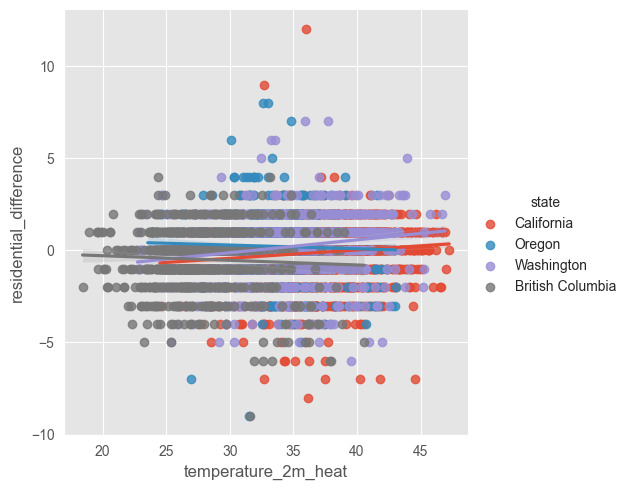

In [18]:
sns.lmplot(mob_vars, x='temperature_2m_heat', y='residential_difference', hue='state')

In [19]:
mob_vars['date'] = pd.to_datetime(mob_vars['date'])

In [20]:
mob_vars['month'] = [x.month for x in mob_vars['date']]

### Add winter temperatures

In [21]:
winter = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/winter_v2.csv')

In [22]:
mob_vars = mob_vars.merge(winter[['location', 'temperature_2m_winter']])

### Build >=5 duration variable

In [23]:
mob_vars['heatwave_dur'] = ['<5 days' if x<5 else '>=5 days' for x in mob_vars['Heat Wave Duration']]
mob_vars['hw_dur_>=_5'] = [0 if x=='<5 days' else 1 for x in mob_vars['heatwave_dur']]

### Get stage_frac variables

In [24]:
mob_vars['stage_frac'] = mob_vars['stage'] / mob_vars['Heat Wave Duration'] * 100


In [25]:
mob_vars['stage_frac'].describe()


count    6100.000000
mean       63.878364
std        28.344134
min         9.090909
25%        40.000000
50%        62.500000
75%       100.000000
max       100.000000
Name: stage_frac, dtype: float64

In [26]:
mob_vars.to_csv(data_path + 'mobility_heat/final_premultivariate_clean_90_v1.csv')

# Add/prepare final variables multivariate


In [27]:
mob_vars = pd.read_csv(data_path + 'mobility_heat/final_premultivariate_clean_90_v1.csv')

## Merge coastal 

In [28]:
coast_variable = pd.read_csv(data_path + 'mobility_heat/multivariate_modelling_v25.csv')
coast_variable.drop_duplicates('location', inplace=True)

In [29]:
mob_vars = mob_vars.merge(coast_variable[['location', 'coast_binary']], on='location')

In [30]:
df = mob_vars.copy()

### Remove Outliers

In [31]:
df['workplaces_difference'] = [np.nan if abs(x) >= df['workplaces_difference'].mean() + (4 * df['workplaces_difference'].std()) else x for x in df['workplaces_difference'] ]

df['residential_difference'] = [np.nan if abs(x) >= df['residential_difference'].mean() + (4 * df['residential_difference'].std()) else x for x in df['residential_difference'] ]

df['grocery_pharmacy_difference'] = [np.nan if abs(x) >= df['grocery_pharmacy_difference'].mean() + (4 * df['grocery_pharmacy_difference'].std()) else x for x in df['grocery_pharmacy_difference'] ]

df['parks_difference'] = [np.nan if abs(x)>= df['parks_difference'].mean() + (4 * df['parks_difference'].std()) else x for x in df['parks_difference'] ]

df['retail_difference'] = [np.nan if abs(x) >= df['retail_difference'].mean() + (4 * df['retail_difference'].std()) else x for x in df['retail_difference'] ]

df['transit_difference'] = [np.nan if abs(x) >= df['transit_difference'].mean() + (4 * df['transit_difference'].std()) else x for x in df['transit_difference'] ]

#v13
df.dropna(how='all', subset=['workplaces_difference', 'residential_difference', 'transit_difference', 'grocery_pharmacy_difference', 'parks_difference', 'retail_difference'], inplace=True)

### Center heat wave temperature variable

In [32]:
df['heat_temp_centered'] = df['temperature_2m_heat'] - df['temperature_2m_heat'].mean()


### Get Large city Variables

In [33]:
df['large_city'] = [x if x in ['Los Angeles County', 'San Diego County', 'Santa Clara County', 'San Francisco County', 'Sacramento County', 'King County', 'Multnomah County', 'Greater Vancouver'] else 'nonmajor' for x  in df['county']]

### Get coast binary as digit

In [34]:
df['coast_binary'] = df['coast_binary'] * 1

### Get June heatwave variable

In [35]:
df = df[['temperature_2m_heat', 'month', 'date_heat', 'control_day', 'Heat Wave Duration', 'large_city', 'date', 'location', 'heat_ID_x', 'workplaces_difference', 'residential_difference', 'grocery_pharmacy_difference', 'retail_difference', 'parks_difference', 'transit_difference', 'state', 'year', 'weekend', 'stage_frac', 'heatwave_dur', 'temp_diff', 'heat_temp_centered', 'coast_binary', 'temperature_2m_winter', 'income_dec', 'over65_dec', 'nonwhite_dec','large_city', 'popdens_dec']]

In [36]:
df['index'] = range(0, len(df))

In [37]:
df['date'] = pd.to_datetime(df['date'])

In [38]:
df['month'] = [x.month for x in df['date']]

In [39]:
df['month'].unique()

array([6, 7, 8, 9])

In [40]:
df['june_hw'] = df.groupby(['heat_ID_x'])['month'].transform(lambda x: 6 in x.unique())
df['june_hw'] = df['june_hw'] * 1



In [41]:
df['month'].value_counts()

8    2347
7    2189
9     796
6     754
Name: month, dtype: int64

In [42]:
df.rename(columns={'heat_ID_x': 'heat_ID'}, inplace=True)

In [43]:
df.reset_index(inplace=True, drop=True)

In [44]:
df['temperature_2m_heat'].describe()

count    6086.000000
mean       33.392871
std         5.037908
min        18.414703
25%        29.775768
50%        33.688816
75%        36.818149
max        47.254585
Name: temperature_2m_heat, dtype: float64

In [45]:
df.to_csv(data_path + 'mobility_heat/mobility_heat_dataset.csv')